In [1]:
# External
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('mu2e.mplstyle')

# Internal
import decoder as dc
# Print all classes defined in decoder
print([name for name in dir(dc) if isinstance(getattr(dc, name), type)])

['EWTWriter', 'HitWriter', 'gr', 'header', 'hit', 'reader', 'status', 'subevent', 'tqdm']


In [245]:
# !ls /scratch/mu2e/mu2ecrv_crv_scorrodi_v3_03_00/OutputData/ -trhl

In [224]:
def process_file(filename= "wb_test_069.bin"): 
    """
    Process binary file into DataFrame
    """
    reader = dc.reader(filename) # Initialise reader
    reader.raw = False # Set raw flag
    hit_writer = dc.HitWriter(n_samples=8) # Initialise hit writer
    reader.get(verbose=0, writer=hit_writer) # Read the file
    return hit_writer.get() # Return DataFrame

df = process_file()
display(df)

/scratch/mu2e/mu2ecrv_crv_scorrodi_v3_03_00/OutputData/wb_test_069.bin:  99%|████████▉| 80.2M/80.8M [00:28<00:00, 2.81MB/s]


,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7
0,1,64,103,2,1,17,25,17,9,5,6
1,1,65,155,-11,-11,2,9,6,-1,-7,-6
2,1,68,152,-13,-13,3,5,-7,-13,-13,-12
3,1,68,168,-15,-9,5,2,-10,-12,-12,-12
4,1,70,119,4,4,20,23,12,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...
3209240,99999,124,18,-2,-1,13,16,6,-2,-2,-1
3209241,99999,124,215,-2,7,16,9,0,-3,-2,-2
3209242,99999,125,94,-8,-6,9,10,-1,-7,-7,-7
3209243,99999,126,33,5,9,23,18,7,5,6,6


In [233]:
# Build a channel map
def get_layers(df): 
    """"
    Assign layer based on channel number
    16 HDMI * 4 SiPMs = 64 
    Should be 16 channels x 4 layers 
    """
    # Get unique channel numbers and sort them
    channels = np.sort(df.channel.unique())
    # Arrange them by layer
    channel_array_4x16 = channels.reshape(-1, 16)
    print(f"4x16 channel array:\n{channel_array_4x16}\n")

    # Create the layer map
    channel_map = {}
    for layer, channels in enumerate(channel_array_4x16):
        for channel in channels:
            channel_map[channel] = layer

    # Add layer column to df
    df["layer"] = df.channel.map(channel_map)

    return df

df = get_layers(df)
display(df)

4x16 channel array:
[[ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]]



,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7,layer
0,1,64,103,2,1,17,25,17,9,5,6,0
1,1,65,155,-11,-11,2,9,6,-1,-7,-6,0
2,1,68,152,-13,-13,3,5,-7,-13,-13,-12,0
3,1,68,168,-15,-9,5,2,-10,-12,-12,-12,0
4,1,70,119,4,4,20,23,12,5,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3209240,99999,124,18,-2,-1,13,16,6,-2,-2,-1,3
3209241,99999,124,215,-2,7,16,9,0,-3,-2,-2,3
3209242,99999,125,94,-8,-6,9,10,-1,-7,-7,-7,3
3209243,99999,126,33,5,9,23,18,7,5,6,6,3


In [234]:
def filter_samples(df, threshold=10):
    """
    Filter rows with samples below threshold
    """
    # Filter columns starting with 's' (samples)
    columns_to_mask = df.filter(like='s').columns
    # Create a mask where all 's' columns are >= threshold
    mask = (df[columns_to_mask] >= threshold).all(axis=1)
    # Apply mask
    df = df[mask]
    # Drop the NaN rows
    df = df.dropna()
    return df

df = filter_samples(df)
# Display
display(df)

,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7,layer
27,1,114,114,15,24,35,27,19,17,18,18,3
45,11,100,157,10,13,25,22,12,10,10,10,2
85,12,117,113,12,12,26,29,22,16,14,15,3
86,12,117,147,12,15,29,26,17,13,12,13,3
91,13,71,150,15,13,26,39,29,18,16,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3209207,99999,67,2,12,28,28,27,24,19,13,11,0
3209208,99999,67,175,11,11,24,31,21,14,13,13,0
3209209,99999,71,106,14,13,30,34,23,17,15,15,0
3209237,99999,117,43,11,18,28,22,16,15,14,13,3


In [243]:
def find_coincidences(df, min_layers=4):
    """
    Find EWTs with 4/4 layers hit
    """
    # First group by EWT and count unique layers hit in each event
    df_layers = df.groupby('EWT')['layer'].agg(['nunique', lambda x: list(sorted(set(x)))])
    df_layers.columns = ['num_layers', 'layers_hit'] # rename columns
    
    # Filter for coincidences 
    df_coincs = df_layers[df_layers["num_layers"] == min_layers]
    
    # Look at the results
    print(f"Total EWTs with layers hit: {len(df_layers_hit)}")
    print(f"EWTs with {n_layers_hit}/4 layers hit: {len(df_coincs)}")

    # Search full DataFrame 
    df_full_coincs = df[df['EWT'].isin(coincs.index)] 

    # Get layer counts 
    df_layer_counts = df_full_coincs.groupby(['EWT', 'layer']).size().unstack(fill_value=0)
    
    # Convert the rows to lists
    lists_layer_counts = df_layer_counts.apply(lambda row: list(row.values), axis=1)
    
    # Convert to back to DataFrame
    df_layer_counts = pd.DataFrame({
        'layer_counts': lists_layer_counts
    })
    
    # Now merge   
    df_coincs = df_coincs.merge(df_layer_counts, left_on='EWT', right_index=True)

    return df_coincs

df_coincs = find_coincidences(df)

display(df_coincs)

Total EWTs with layers hit: 94792
EWTs with 4/4 layers hit: 82


,num_layers,layers_hit,layer_counts
EWT,,,
4313,4,"[0, 1, 2, 3]","[3, 1, 1, 2]"
4563,4,"[0, 1, 2, 3]","[1, 1, 1, 1]"
6931,4,"[0, 1, 2, 3]","[1, 1, 1, 1]"
8435,4,"[0, 1, 2, 3]","[3, 1, 1, 3]"
8527,4,"[0, 1, 2, 3]","[3, 1, 1, 2]"
...,...,...,...
95430,4,"[0, 1, 2, 3]","[1, 1, 1, 1]"
96337,4,"[0, 1, 2, 3]","[2, 1, 1, 4]"
96840,4,"[0, 1, 2, 3]","[5, 1, 1, 1]"


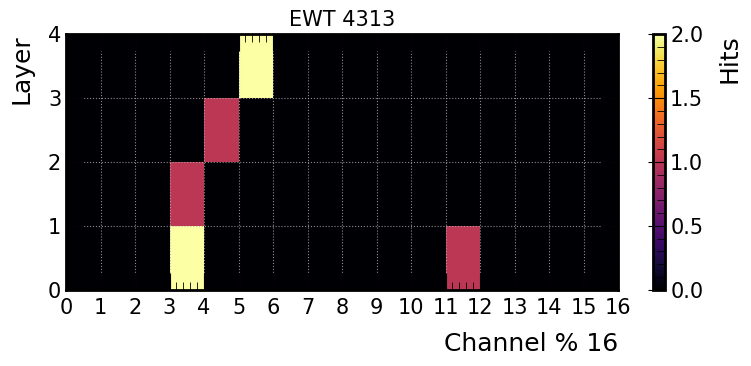

In [244]:
def display_ewt(df, ewt): 
    """
    Event display for one EWT
    """
    # Search for this EWT
    df_ewt = df[df.EWT == ewt]    
    
    # Create figure
    plt.figure(figsize=(8, 4))
    
    # Create 2D histogram
    plt.hist2d(df_ewt.channel % 16, df_ewt.layer, 
               bins=[16, 4], 
               range=[[0, 16], [0, 4]],
               cmap="inferno"
              )  
    
    plt.title(f"EWT {ewt}")
    plt.colorbar(label=f"Hits")
    plt.xlabel("Channel % 16")
    plt.ylabel("Layer")
    # Add grid 
    plt.xticks(range(0, 17, 1))
    plt.grid(True) 
    plt.tight_layout()
    plt.savefig(f"images/display_ewt_{ewt}.png", dpi=300)
    plt.show()
    plt.close()

# Pick a specific EWT from the multi-layer events
ewt = df_coincs.index[0]  # taking first multi-layer event
display_ewt(df, ewt)